In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch
from tqdm.notebook import tqdm


import util, cam, draw, constants

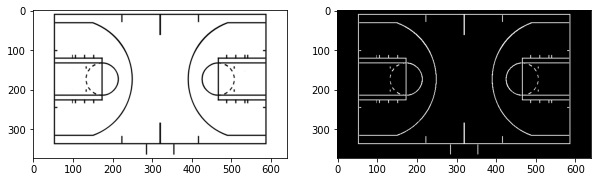

In [2]:
img = plt.imread('/home/akarshkumar0101/Insync/akarshkumar0101@gmail.com/Google Drive/nba-3d-data/court.png')
gray = cv2.cvtColor(img, cv2.COLOR_RGBA2GRAY)
binary = gray<0.1
plt.figure(figsize=(10,3))
plt.subplot(121);plt.imshow(img)
plt.subplot(122);plt.imshow(binary, cmap='gray')
plt.show()

In [3]:
scale = binary.shape[0]
y = (np.arange(binary.shape[0])-binary.shape[0]/2.)/scale
x = (np.arange(binary.shape[1])-binary.shape[1]/2.)/scale
y, x = np.meshgrid(y, x, indexing='ij')
z, x = y[binary], x[binary]
y = np.zeros_like(x)
X_w = torch.from_numpy(np.stack([x,z,y], axis=-1)).float()

In [4]:
gray = binary.astype(np.uint8)*255

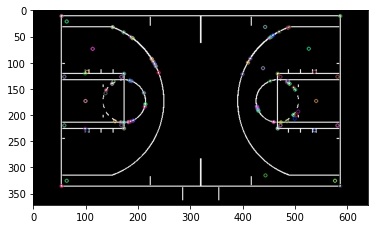

In [5]:
sift = cv2.SIFT_create()
kp = sift.detect(gray, None)
temp = gray.copy()
temp = cv2.drawKeypoints(temp,kp,img)
plt.imshow(temp)

# Convention Used
## World Coordinates
-Z is direction of gravity.
# Camera Coordinates
+Z is looking forward.
+X is looking left.
+Y is looking up.


We know that $x_i = x_cfm_x/z_c + u_0$.
We instead define $(f_x, f_y) = f(m_x, m_y)$.

We will let $u_0=v_0=0$

We will crop the image in $x$ and $y$ at $(-1, 1)$ and the $f_x, f_y$ will determine how "fast or slow" the x coordinate will grow and shrink and adjust to our cropping window.
We will display the cropping window with whatever height x width we want to.

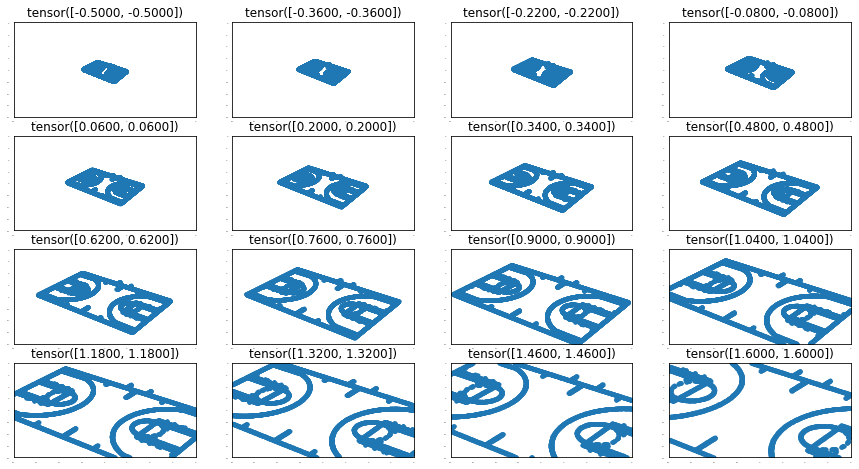

In [6]:
plt.figure(figsize=(15, 8))
r = 1.+.05*torch.randn(1)[0]
theta = torch.rand(1)[0]*2*np.pi
x,y  = r*torch.cos(theta), r*torch.sin(theta)
z = 1.5+.3*torch.randn(1)[0].abs()

for i in range(16):
    plt.subplot(4, 4, i+1)
    f = torch.linspace(-0.5, 1.6, 16)[i]
    f = torch.stack([f,f])
    dofs_cam = cam.calc_dofs_cam(torch.tensor([[x, y, z]]), torch.tensor([[0.001,0.001,0.001]]), f[None, :])[0]
    draw.show_cam_view(X_w, dofs_cam)
    plt.title(f)


In [7]:
def generate_random_views(*shape):
    r = 1+.2*torch.randn(shape)
    theta = torch.rand(shape)*2*np.pi
    x,y  = r*torch.cos(theta), r*torch.sin(theta)
    z = 0.3+1.*torch.randn(shape).abs()
    f = (torch.rand(*shape, 2)*(1.6--0.5) - 0.5)
    x = torch.stack([x,y,z], dim=-1)
    pts_to = 0.3*torch.randn_like(x)
    
    dofs_cam = cam.calc_dofs_cam(x,pts_to, f)
    return dofs_cam, pts_to

# X sould be of shape (..., 8) and be from a standard multivariate gaussian
def gaussian2cam(X):
    r = .4+.8*torch.sigmoid(X[..., 0])
    theta = 2*np.pi*X[..., 1]
    z = .1+.3*X[..., 2].abs()
    x, y = r*torch.cos(theta), r*torch.sin(theta)
    pos = torch.stack([x,y,z], dim=-1)
    
    px, py, pz = .4+.2*X[..., 3], .2*X[..., 4], .1*X[..., 5].abs()
    pts_to = torch.stack([px, py, pz], dim=-1)
    
    fxy = 0.5*X[..., 6:]
    
    dofs_cam = cam.calc_dofs_cam(pos, pts_to, fxy)
    
    return dofs_cam, pts_to

In [8]:
views_court = [[0,0], [90, 0], [25, 45]]
region_court = [[-.7,.7], [-.7, .7], [0, .7]]

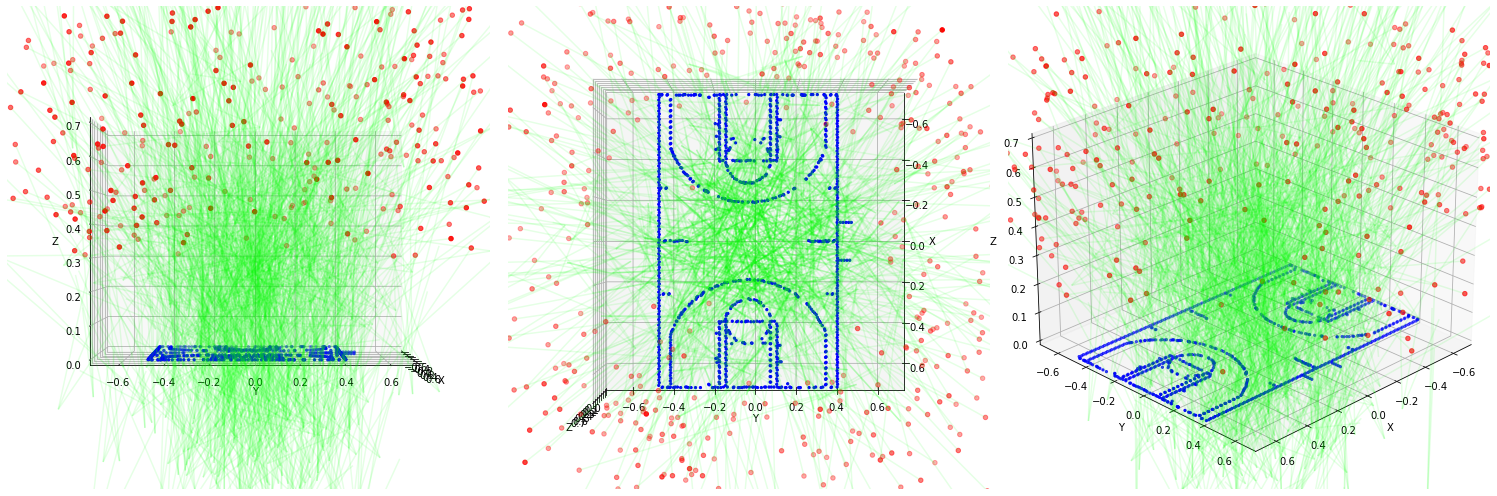

In [9]:
dofs_cams, pts_to = generate_random_views(500)
for ax in draw.multi_view(views_court, region_court)[0]:
    ax.scatter3D(*X_w[::10].transpose(0,1), marker='.', color='b')
    ax.scatter3D(*dofs_cams[:, :3].transpose(0,1), color='r')
    ax.quiver3D(*dofs_cams[:, :3].transpose(0,1), 
                *(pts_to-dofs_cams[:, :3]).transpose(0,1), color=[0., 1., 0., 0.1])

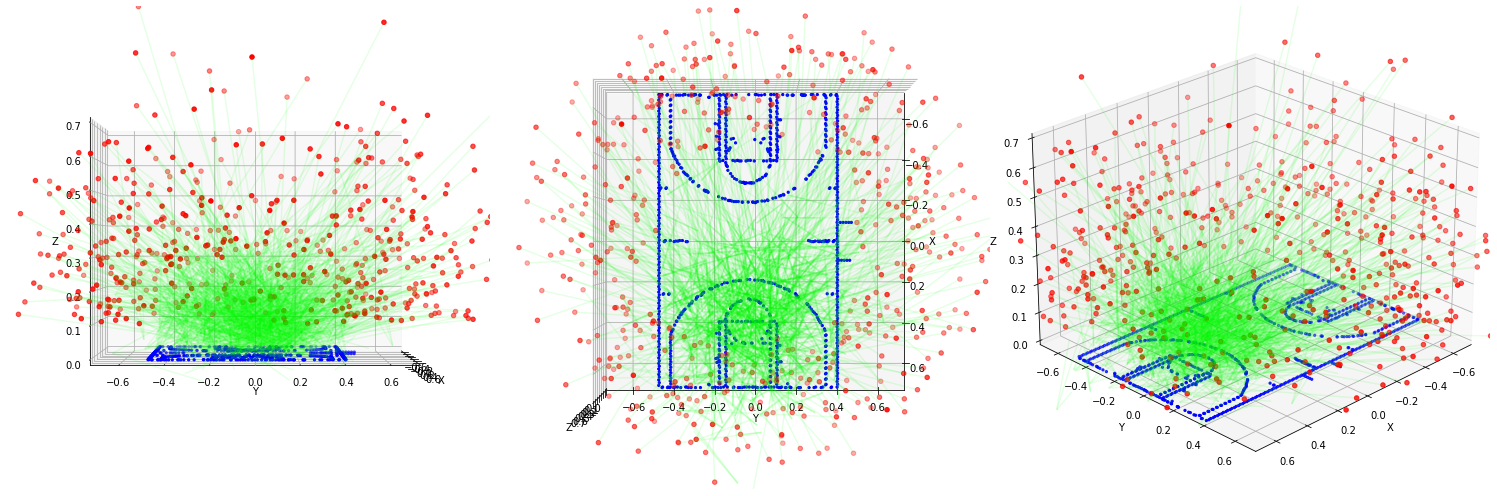

In [10]:
x = torch.distributions.MultivariateNormal(torch.zeros(8), torch.eye(8)).sample((500,))
dofs_cams, pts_to = gaussian2cam(x)
for ax in draw.multi_view(views_court, region_court)[0]:
    ax.scatter3D(*X_w[::10].transpose(0,1), marker='.', color='b')
    ax.scatter3D(*dofs_cams[:, :3].transpose(0,1), color='r')
    ax.quiver3D(*dofs_cams[:, :3].transpose(0,1), 
                *(pts_to-dofs_cams[:, :3]).transpose(0,1), color=[0., 1., 0., 0.1])

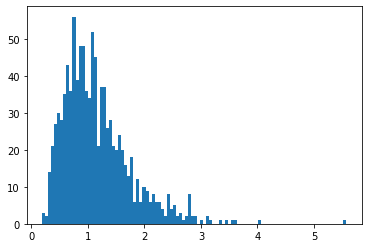

In [11]:
plt.hist(np.e**(0.5*torch.randn(1000).numpy()), bins=100)
plt.show()

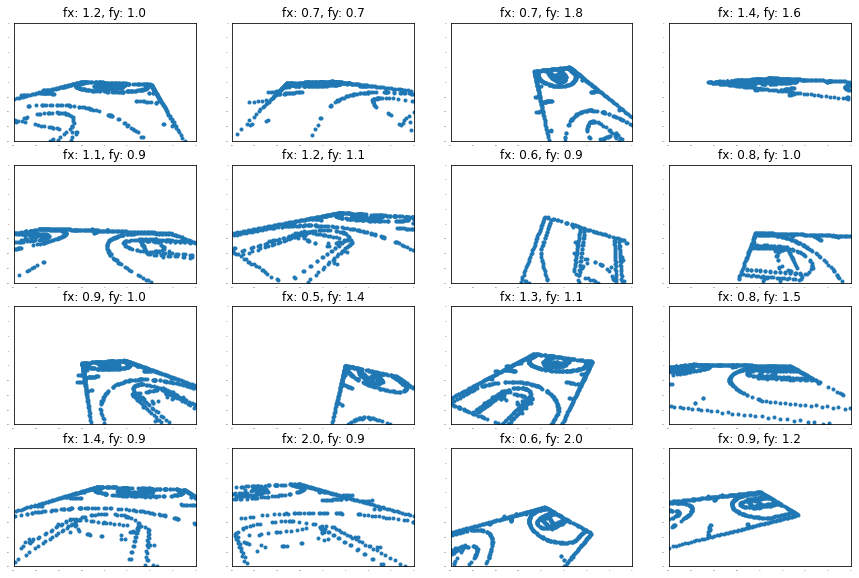

In [12]:
plt.figure(figsize=(15, 10))
for i in range(16):
    plt.subplot(4,4,i+1)
    dofs_cam = dofs_cams[i].clone()
    draw.show_cam_view(X_w[::10], dofs_cam)
    plt.title(f'fx: {np.e**dofs_cam[6].item():1.1f}, fy: {np.e**dofs_cam[7].item():1.1f}')


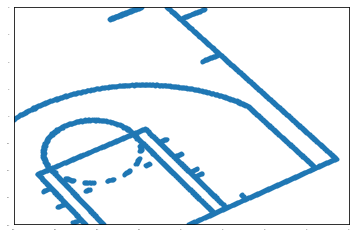

In [13]:
dofs_cam = cam.calc_dofs_cam(torch.tensor([.7, 0., .8]),torch.tensor([.4, .1, .0]), torch.tensor([.7, .7]))
dofs_cam = cam.calc_dofs_cam(torch.tensor([.7, 0., 1.5]),torch.tensor([.4, .2, .0]), torch.tensor([1.4, 1.4]))
draw.show_cam_view(X_w[::1], dofs_cam)

In [14]:
X_w_down = X_w[::10, :]

# Loss function

In [15]:
"""
alpha=0 will take the mean.
alpha=.2 will be very close to max.
alpha=-.2 will be very close to min.
"""
def smooth_max(x, alpha, dim=-1):
    # unstable version:
    # return (x*(alpha*x).exp()).sum()/((alpha*x).exp()).sum()
    return ((alpha*x).softmax(dim=dim)*x).sum(dim=dim)

def pt2pt_dist(p1, p2):
    # (..., N1, D) and (..., N2, D)
    return (p1[..., None, :]-p2[..., None, :, :]).norm(dim=-1).min(dim=-1).values

def pt2pt_dist_soft(p1, p2, alpha=-.2):
    # (..., N1, D) and (..., N2, D)
    return smooth_max((p1[..., None, :]-p2[..., None, :, :]).norm(dim=-1), alpha=alpha, dim=-1)

def fitness(x, X_i_true):
    if type(x) is not torch.Tensor:
        x = torch.tensor(x).float()
    dofs_cam, _ = gaussian2cam(x)
    X_i, vis_mask = util.project_to_cam(X_w_down, dofs_cam)
    X_i = X_i[vis_mask]
    return pt2pt_dist(X_i, X_i_true).mean().item()

# Energy Minimization with Population Based Search

In [16]:
import cma

In [17]:
torch.manual_seed(0)
x = torch.distributions.MultivariateNormal(torch.zeros(8), torch.eye(8)).sample()
dofs_cam_true, _ = gaussian2cam(x)

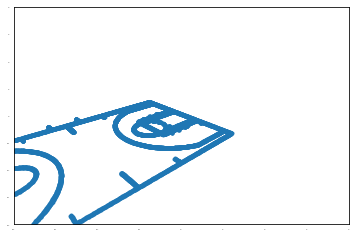

In [18]:
draw.show_cam_view(X_w, dofs_cam_true)

In [19]:
X_i_true, vis_mask = util.project_to_cam(X_w_down, dofs_cam_true)
X_i_true=X_i_true[vis_mask]

In [20]:
import functools

In [22]:
es = cma.CMAEvolutionStrategy(8*[0], 1.0)
fitness_func = functools.partial(fitness, X_i_true = X_i_true)
i = 0
while not es.stop():
    solutions = es.ask(10)
    print(i)
    es.tell(solutions, [fitness_func(x) for x in solutions])
#     es.logger.add()
#     es.disp()
    i+=1

(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 8 (seed=99050, Thu Oct 29 20:41:25 2020)
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147


KeyboardInterrupt: 

final/bestever f-value = 3.373236e-03 2.780910e-03
incumbent solution: [20.371317044366652, -6.977196099287387, 20.399410543764677, 3.4937191412955144, 3.8560085803768973, 2.013550439117731, -4.481034307261087, -31.311951329748936]
std deviation: [1.431762735818099, 1.4094939159758053, 3.479190477392293, 0.6079123150498797, 1.2904698223275826, 2.0188483702304243, 0.591333360625096, 3.177563814786935]


/home/akarshkumar0101/.local/lib/python3.8/site-packages/cma/logger.py:874: MatplotlibDeprecationWarning: The global colormaps dictionary is no longer considered public API.
  color = iter(pyplot.cm.cmap_d['plasma_r'](np.linspace(0.35, 1,


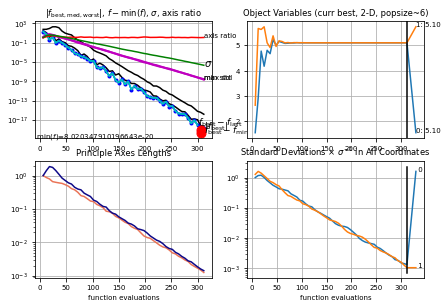

In [23]:
es.result_pretty()
cma.plot()

In [27]:
es.best.x

array([ 12.20350787, -11.71195507,  20.44415694,   1.14453234,
         6.98529131,  19.62043196,  -4.59103226, -31.55815392])

# Energy Minimization with Supervised Rendering Loss

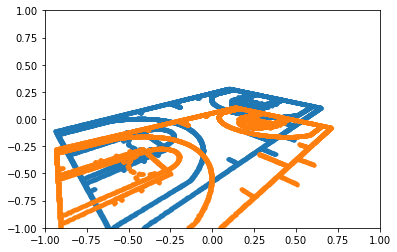

In [43]:
dofs_cam = calc_dofs_cam(torch.tensor([.6,.6, 0.6]), 
                         torch.tensor([0., 0., 0.]), 
                         fxy=torch.tensor([1., 1.]))
dofs_cam_optim = dofs_cam.clone()
torch.manual_seed(10)
dofs_cam_optim = dofs_cam_optim + 0.1*torch.randn(dofs_cam_optim.shape)

show_cam_view(X_w, dofs_cam)
show_cam_view(X_w, dofs_cam_optim)

loss:  0.08055940270423889
pt2pt:  0.08055940270423889
tensor([1., 1.], grad_fn=<SliceBackward>)



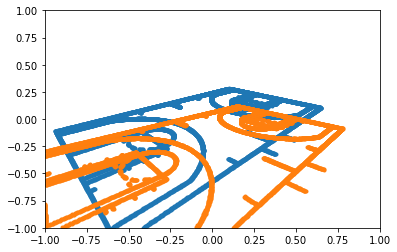

loss:  0.07483840733766556
pt2pt:  0.07483840733766556
tensor([1., 1.], grad_fn=<SliceBackward>)

loss:  0.06773365288972855
pt2pt:  0.06773365288972855
tensor([1., 1.], grad_fn=<SliceBackward>)

loss:  0.059148408472537994
pt2pt:  0.059148408472537994
tensor([1., 1.], grad_fn=<SliceBackward>)

loss:  0.049734748899936676
pt2pt:  0.049734748899936676
tensor([1., 1.], grad_fn=<SliceBackward>)

loss:  0.039606861770153046
pt2pt:  0.039606861770153046
tensor([1., 1.], grad_fn=<SliceBackward>)

loss:  0.027756936848163605
pt2pt:  0.027756936848163605
tensor([1., 1.], grad_fn=<SliceBackward>)

loss:  0.0199738759547472
pt2pt:  0.0199738759547472
tensor([1., 1.], grad_fn=<SliceBackward>)

loss:  0.02252376452088356
pt2pt:  0.02252376452088356
tensor([1., 1.], grad_fn=<SliceBackward>)

loss:  0.02725219912827015
pt2pt:  0.02725219912827015
tensor([1., 1.], grad_fn=<SliceBackward>)

loss:  0.028437091037631035
pt2pt:  0.028437091037631035
tensor([1., 1.], grad_fn=<SliceBackward>)

loss:  0.027

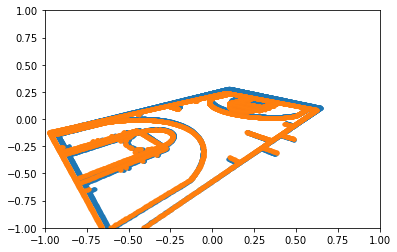

loss:  0.015548312105238438
pt2pt:  0.015548312105238438
tensor([1., 1.], grad_fn=<SliceBackward>)

loss:  0.01611088030040264
pt2pt:  0.01611088030040264
tensor([1., 1.], grad_fn=<SliceBackward>)

loss:  0.015160067938268185
pt2pt:  0.015160067938268185
tensor([1., 1.], grad_fn=<SliceBackward>)

loss:  0.013678614981472492
pt2pt:  0.013678614981472492
tensor([1., 1.], grad_fn=<SliceBackward>)

loss:  0.011612003669142723
pt2pt:  0.011612003669142723
tensor([1., 1.], grad_fn=<SliceBackward>)

loss:  0.010788671672344208
pt2pt:  0.010788671672344208
tensor([1., 1.], grad_fn=<SliceBackward>)

loss:  0.011268536560237408
pt2pt:  0.011268536560237408
tensor([1., 1.], grad_fn=<SliceBackward>)

loss:  0.011875171214342117
pt2pt:  0.011875171214342117
tensor([1., 1.], grad_fn=<SliceBackward>)

loss:  0.012426052242517471
pt2pt:  0.012426052242517471
tensor([1., 1.], grad_fn=<SliceBackward>)

loss:  0.012365964241325855
pt2pt:  0.012365964241325855
tensor([1., 1.], grad_fn=<SliceBackward>)

lo

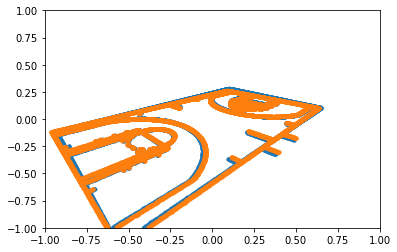

loss:  0.007314519491046667
pt2pt:  0.007314519491046667
tensor([1., 1.], grad_fn=<SliceBackward>)

loss:  0.007700114510953426
pt2pt:  0.007700114510953426
tensor([1., 1.], grad_fn=<SliceBackward>)

loss:  0.008163988590240479
pt2pt:  0.008163988590240479
tensor([1., 1.], grad_fn=<SliceBackward>)

loss:  0.007517179474234581
pt2pt:  0.007517179474234581
tensor([1., 1.], grad_fn=<SliceBackward>)

loss:  0.006599924992769957
pt2pt:  0.006599924992769957
tensor([1., 1.], grad_fn=<SliceBackward>)

loss:  0.006487403530627489
pt2pt:  0.006487403530627489
tensor([1., 1.], grad_fn=<SliceBackward>)

loss:  0.00666541513055563
pt2pt:  0.00666541513055563
tensor([1., 1.], grad_fn=<SliceBackward>)

loss:  0.006583193317055702
pt2pt:  0.006583193317055702
tensor([1., 1.], grad_fn=<SliceBackward>)

loss:  0.00583241879940033
pt2pt:  0.00583241879940033
tensor([1., 1.], grad_fn=<SliceBackward>)

loss:  0.005345774814486504
pt2pt:  0.005345774814486504
tensor([1., 1.], grad_fn=<SliceBackward>)

loss

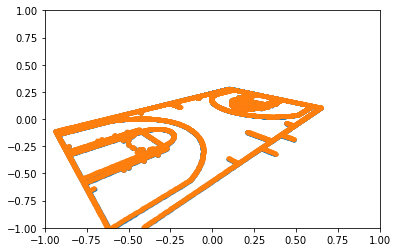

loss:  0.0014613074017688632
pt2pt:  0.0014613074017688632
tensor([1., 1.], grad_fn=<SliceBackward>)

loss:  0.0028742256108671427
pt2pt:  0.0028742256108671427
tensor([1., 1.], grad_fn=<SliceBackward>)

loss:  0.0025908953975886106
pt2pt:  0.0025908953975886106
tensor([1., 1.], grad_fn=<SliceBackward>)

loss:  0.0015774922212585807
pt2pt:  0.0015774922212585807
tensor([1., 1.], grad_fn=<SliceBackward>)

loss:  0.002931102178990841
pt2pt:  0.002931102178990841
tensor([1., 1.], grad_fn=<SliceBackward>)

loss:  0.0020009265281260014
pt2pt:  0.0020009265281260014
tensor([1., 1.], grad_fn=<SliceBackward>)




KeyboardInterrupt: 

In [44]:
dofs_cam_optim_p = dofs_cam_optim[:6]
opt = torch.optim.Adam([{'params': dofs_cam_optim_p, 'lr': 0.01}])
dofs_cam_optim_p.requires_grad_()

for i in tqdm(range(200)):
    dofs_cam_optim = torch.cat([dofs_cam_optim_p, torch.tensor([1., 1.])])
    X_true, vis_mask = project_to_cam(X_w_down, dofs_cam)
    X_true = X_true[vis_mask]
    
    X_i, vis_mask = project_to_cam(X_w_down, dofs_cam_optim)
    X_i = X_i[vis_mask]
    
#     loss = pt2pt_dist(X_i, X_true)
    loss1 = pt2pt_dist(X_i, X_true)
    loss2 = pt2pt_dist_soft(X_true, X_i)
    loss = (loss1).mean()#+(loss2*1000).pow(2).mean()
    print('loss: ', loss.item())
    print('pt2pt: ', pt2pt_dist(X_i, X_true).mean().item())
    print(dofs_cam_optim[6:])
    print()
    
    opt.zero_grad()
    loss.backward()
    opt.step()
    
    if i%20==0:
        show_cam_view(X_w, dofs_cam)
        show_cam_view(X_w, dofs_cam_optim.detach())
        plt.show()

In [45]:
dofs_cam

tensor([ 0.6000,  0.6000,  0.6000,  2.0521, -0.8500, -0.4400,  1.0000,  1.0000])

In [46]:
dofs_cam_optim

tensor([ 0.5961,  0.5997,  0.6050,  2.0547, -0.8506, -0.4369,  1.0000,  1.0000],
       grad_fn=<CatBackward>)

In [47]:
dofs_cam_optim = dofs_cam_optim.detach()

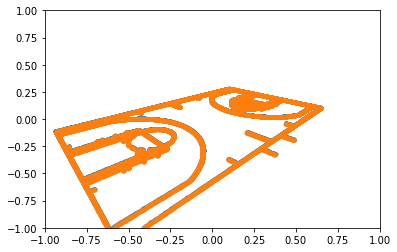

In [48]:
show_cam_view(X_w, dofs_cam)
show_cam_view(X_w, dofs_cam_optim)

In [52]:
X_i = X_i.detach()

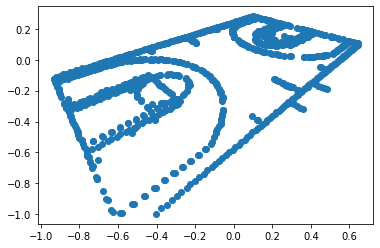

In [54]:
plt.scatter(-X_i[:, 0], X_i[:, 1])